# Decoy Generation Results

Here, we will re-produce the results from [here](file:///C:/Users/kia/Downloads/Metabolomics%20Internship/Papers/Converting%20from%20proteomics%20to%20metabolomics.pdf). In particular, we will produce the QQ-plots of q-values for FDR assessment, and histograms of estimated p-values for null model evaluation.

## Setup

In [2]:
from matchms import Scores, Spectrum
from matchms.similarity import CosineGreedy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preliminary Functions

In [39]:
#Preliminary functions required for reproducing results


#Function that produces an array of cosine scores (based on the greedy algorithm from matchms) from reference and query spectra

def scores_array(query_spectra, reference_spectra, cos_tolerance = 0.1):
    
    cosine_greedy = CosineGreedy(tolerance = cos_tolerance)
    scores = []
    for query in query_spectra:
        
        for reference in reference_spectra:
            
            scores += [cosine_greedy(query, reference)[0]]
    return np.array(scores)

    

## FDR Estimation

In [40]:
#Estimating FDRs for 1000 query spectrum for 100 different cosine score thresholds



#quey_spectra is list of query spectra (from target database)
#target_spectra is list of target spectra (target database)
#decoy_spectra is list of decoy spectra (decoy database)
#Assume all necessary processing is done.

score_thresholds = np.arange(0, 1, 0.01)                 #Using 100 score thresholds

#Getting hits for each query spectrum in reference spectra
#Type_query here is whether it's target or decoy hit. True is for target hit, False for decoy hit.
#(Using indices rather than GNPS IDs for now)

def get_hits(query_spectra, reference_spectra, cos_tolerance, type_hit):
    
    no_query = len(query_spectra)
    hits = pd.DataFrame({'Cosine Score':pd.Series([0]*no_query, dtype='float'), 'Reference InChl':pd.Series([0]*no_query, dtype='str'), 'Reference Id':pd.Series([0]*no_query, dtype='str'), 'Query InChl':pd.Series([0]*no_query, dtype='str'), 'Query Id':pd.Series([0]*no_query, dtype='str'), 'Target/Decoy Hit':pd.Series([0]*no_query, dtype='bool')})
    for i in range(no_query):
    
        query_scores = scores_array([query_spectra[i]], reference_spectra, cos_tolerance = cos_tolerance)
        max_reference = np.argsort(query_scores)[-1]
        reference_inchikey = reference_spectra[max_reference].get("inchikey")
        reference_inchikey = reference_inchikey if reference_inchikey else np.nan
        reference_id = reference_spectra[max_reference].get("id")
        reference_id = reference_id if reference_id else np.nan
        query_inchikey = query_spectra[i].get("inchikey")           
        query_id = query_spectra[i].get("id")
        
        hit = [query_scores[max_reference], reference_inchikey, reference_id, query_inchikey, query_id, type_hit]
        hits.iloc[i, :] = hit                 
    return hits

#Estimate FDR from dataframe of sorted hits for certain cosine score threshold
#FDR is estimated as no. decoy hits above threshold/no. target hits above threshold
#Returns np.nan if no. targets is 0

def estimate_FDR(hits, threshold):
    
    thresholds_hits = hits[hits["Cosine Score"] > threshold]
    targets = sum(thresholds_hits["Target/Decoy Hit"] == 1)
    decoys = sum(thresholds_hits["Target/Decoy Hit"] == 0)
    if targets != 0 :
        
        FDR_estimate = decoys/targets
        return FDR_estimate
    else:
        
        print("No targets found. No FDR estimate available.")
        return np.nan
    


decoy_hits = get_hits(query_spectra, decoy_spectra, cos_tolerance = 10, type_hit = False)
target_hits = get_hits(query_spectra, target_spectra, cos_tolerance = 10, type_hit = True)
all_hits = pd.concat([decoy_hits, target_hits], ignore_index = True)
all_hits = all_hits.sort_values(by = ["Cosine Score"], ascending= False)

## Estimating Q-Values

In [41]:
#Estimating q-values for (all) target and decoy hits for query spectra



#Going through each hit from all hits, and find their q-value:
#Go through all the possible score thresholds.
#Calculate their FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

estimated_q_values = []
for index, hit in all_hits.iterrows():
    
    estimate_FDRs = []
    hit_score = hit["Cosine Score"]
    thresholds = score_thresholds[score_thresholds < hit_score]
    for threshold in thresholds:
        
        FDR = estimate_FDR(all_hits, threshold)
        if not np.isnan(FDR):
            
            estimate_FDRs += [FDR]    
    if estimate_FDRs != []:

        estimated_q_values += [min(estimate_FDRs)]
    else:
        
        estimated_q_values += [np.nan]

## Calculating True FDRs

In [42]:
#Calculating True FDRs


    
#Calculate FDR from dataframe of sorted hits for certain cosine score threshold
#False hits are hits which are not the true identity for associated query spectra
#FDR is estimated as (no. false hits + no. decoy hits)/no. target hits above threshold
#Returns np.nan if no. targets is 0

def calculate_FDR(hits, threshold):
    
    thresholds_hits = hits[hits["Cosine Score"] > threshold]
    no_targets = sum(thresholds_hits["Target/Decoy Hit"] == 1)
    no_decoys = sum(thresholds_hits["Target/Decoy Hit"] == 0)
    
    target_hits = thresholds_hits[thresholds_hits["Target/Decoy Hit"] == 1]
    no_false_hits = sum(target_hits["Reference InChl"] != target_hits["Query InChl"])
    if no_targets != 0:
        
        FDR = (no_decoys + no_false_hits)/no_targets
        return FDR
    else:
        
        print("No targets found. No FDR estimate available.")
        return np.nan

## Calculating True Q-Values

In [43]:
#Calculating true q-values for (all) target and decoy hits for query spectra



#Going through each hit from all hits, and find their true q-value:
#Go through all the possible score thresholds.
#Calculate their true FDRs.
#The min. FDR at which this hit is in the output list is the q-value.

true_q_values = []
for index, hit in all_hits.iterrows():
    
    true_FDRs = []
    hit_score = hit["Cosine Score"]
    thresholds = score_thresholds[score_thresholds < hit_score]
    for threshold in thresholds:
        
        FDR = calculate_FDR(all_hits, threshold)
        if not np.isnan(FDR):
            
            true_FDRs += [FDR]    
    if true_FDRs != []:

        true_q_values += [min(true_FDRs)]
    else:
        
        true_q_values += [np.nan]

## QQ-plots of True Q-Values vs. Esimated Q-Values

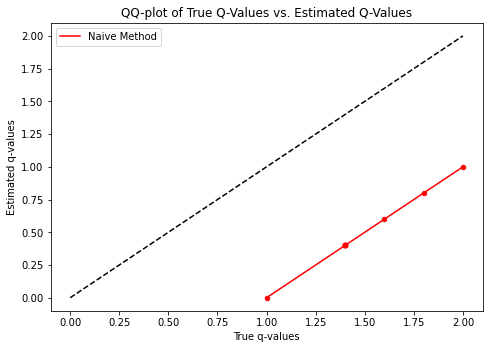

In [56]:
#QQ-plots of true qq-values against estimated q-values.



#Sorting q-values and removing nas.

estimated_q_values = np.array(estimated_q_values)
true_q_values = np.array(true_q_values)
order = np.argsort(estimated_q_values)
estimated_q_values = estimated_q_values[order]
true_q_values = true_q_values[order]

estimated_non_nans = np.where(~np.isnan(estimated_q_values))[0]
true_non_nans = np.where(~np.isnan(true_q_values))[0]
non_nans = np.intersect1d(estimated_non_nans, true_non_nans, assume_unique = True)
etimated_q_values = estimated_q_values[non_nans]
true_q_values = true_q_values[non_nans]

#Producing QQ-plot for the two decoy methods.

xmax = np.max(estimated_q_values)
ymax = np.max(true_q_values)
ax_lim = xmax if xmax > ymax else ymax 

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(true_q_values, estimated_q_values, color = "r", s=20)
ax.plot(true_q_values, estimated_q_values, color = "r", label = "Naive Method")
ax.plot([0, ax_lim], [0,ax_lim],"r--", color = "black")

#ax.set_xlim(0, ax_lim)
#ax.set_ylim(0, ax_lim)
ax.set_ylabel('Estimated q-values')
ax.set_xlabel('True q-values')
ax.set_title('QQ-plot of True Q-Values vs. Estimated Q-Values')
ax.legend(loc="upper left")
plt.show()

## Testing

In [38]:
#Testing

#Test dataset, randomly generated
#5 query spectra, 100 target spectra, 100 decoy spectra

#Function to generate n random spectra with intensity and mz range

def generate_random_spectra(n, id_key, type_spectra, intensity_range = (0.1, 0.7), mz_range = (30, 300), peaks_range = (3, 11)):
    
    spectra = []
    for i in range(n):
        
        no_peaks = np.random.randint(peaks_range[0], peaks_range[1])
        intensities = np.random.uniform(intensity_range[0], intensity_range[1], no_peaks)
        mzs = np.random.uniform(mz_range[0], mz_range[1], no_peaks)
        mzs = np.sort(mzs)
        inchikey = np.random.randint(0, 11)
        spectrum = Spectrum(intensities=intensities, mz=mzs, metadata={'id': f'spectrum {i}{id_key}'})
        if type_spectra:
            
            inchikey = np.random.randint(0, 16)
            spectrum.set("inchikey", f'{inchikey}')
        spectra += [spectrum]
    return spectra


target_spectra = generate_random_spectra(105, id_key = "T", type_spectra = True)
decoy_spectra = generate_random_spectra(100, id_key = "D", type_spectra = False)
query_choices = np.random.choice(range(len(target_spectra)), 5, replace = False)
query_spectra = [target_spectra[query_choice] for query_choice in query_choices]

target_spectra = [target_spectra[i] for i in range(len(target_spectra)) if i not in query_choices]